In [8]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [9]:
class ResetMcl(Mcl): ###resetmcl4 （random_reset, sensor_resetting_drawは省略）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, amcl_params={"slow":0.001, "fast":0.1, "nu":3.0}): #amcl_paramsを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.amcl_params = amcl_params #追加
        self.slow_term_alpha, self.fast_term_alpha = 1.0, 1.0 #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs):
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles)
            
    def sensor_resetting(self, observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation])
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
    def adaptive_resetting(self, observation):
        if len(observation) == 0: return #追加
        
        #＃センサリセットするパーティクルの数を決める##
        alpha = sum([p.weight for p in self.particles])
        self.slow_term_alpha += self.amcl_params["slow"]*(alpha - self.slow_term_alpha)
        self.fast_term_alpha += self.amcl_params["fast"]*(alpha - self.fast_term_alpha)
        sl_num = len(self.particles)*max([0, 1.0-self.amcl_params["nu"]*self.fast_term_alpha/self.slow_term_alpha])
        
        self.resampling() #とりあえず普通にリサンプリング
        
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        for n in range(int(sl_num)): #n回パーティクルを選んで姿勢を変える（2回以上姿勢を変えられるパーティクルがあるけどとりあえず気にしない）
            p = random.choices(self.particles)[0] #一つ選ぶ
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
    
        self.set_ml()
        self.adaptive_resetting(observation) #変更

In [10]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(300, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 300)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m, phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (pf)

<IPython.core.display.Javascript object>


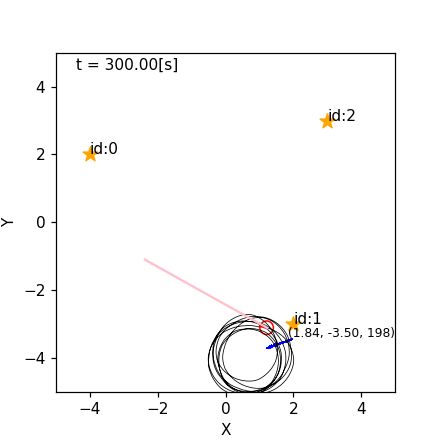

In [11]:
pf = trial(True)

In [ ]:
pf.log
long = [e[0] for e in pf.log]
short = [e[1] for e in pf.log]
s_l = [e[1]/e[0] for e in pf.log]
#plt.hist(s_l)
#plt.show()
min(s_l), max(s_l)

In [ ]:
min(s_l), max(s_l)

In [ ]:
def trial_phantom(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(300, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 1000)
    a = EstimatorAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m, phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (pf)

In [ ]:
pf = trial_phantom(True)

In [ ]:
pf.long_term_alpha

In [ ]:
pf.short_term_alpha